In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geatpy as ga # 导入geatpy库
import time

np.seterr(divide='ignore', invalid='ignore') #避免除零错误 

C:\Users\fengzi\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## 结果绘图

In [2]:
#绘图函数
def plot(Tins,data,filename):
    '''
    Tins: 预测结果
    data: 数据集
    filename: 图片保存文件名
    '''
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111)

    x_coords = [x for x in range(len(Tins))]

    ax.plot(x_coords,Tins,"g--",label = "Predict")
    ax.plot(x_coords,data["tin"],"r-",label = "exact")

    ax.set_xlabel("Time",fontsize = 10)
    ax.set_ylabel("Tin",fontsize = 10)
    ax.set_title("using 3R3C model to predict the Tin",fontsize = 10)
    ax.legend(loc="best")
    plt.savefig(filename,dpi=400,bbox_inches="tight")
    plt.show()

In [3]:
#目标函数
def costFunc(Tins,data):
    return np.sqrt(np.sum((Tins - data['tin'])**2) / (data["tin"].shape[0] - 1))

## RungeKutta4

In [4]:
class RungeKutta4():
    
    def __init__(self,Touts,Tw0,Tin0,Tim0,c0,c1,c2,r0,r1,r2,Qss,Qins,Qcs,h=0.02):
        self.Touts = Touts
        self.Tw0 = Tw0
        self.Tin0 = Tin0
        self.Tim0 = Tim0
        self.c0 = c0
        self.c1 = c1
        self.c2 = c2
        self.r0 = r0
        self.r1 = r1
        self.r2 = r2
        self.Qss = Qss
        self.Qins = Qins
        self.Qcs = Qcs
        self.h = h
        
    #微分方程一
    #R下标：Rw,i :0; Rw,j : 1; Rim : 2
    #c下标：Cw: 0; Cin: 1; Cim : 2
    def f_Tw(self,Tout,Tw,Tin,Tim):
        return ((Tout-Tw)/self.r0 - (Tw - Tin)/self.r1)/self.c0
    
    #微分方程二
    def f_Tim(self,Tout,Tw,Tin,Tim):
        return ((Tin - Tim)/self.r2)/self.c2
    
    #微分方程三
    def f_Tin(self,Tout,Tw,Tin,Tim,Qs,Qin,Qc):
        return ((Tim-Tin)/self.r2 + (Tw - Tin)/self.r1 +(Qs + Qin + Qc) )/self.c1
    
    #四阶Runge-Kutta法
    #定步长
    def run(self):

        Tws = []
        Tins = []
        Tims = []
        Tw_i = Tw0
        Tin_i = Tin0
        Tim_i = Tim0

        for i in range(len(self.Touts)):
            Tout = self.Touts[i]
            Tws.append(Tw_i)
            Tins.append(Tin_i)
            Tims.append(Tim_i)

            k1 = self.h*self.f_Tw(Tout, Tw_i, Tin_i, Tim_i)
            m1 = self.h*self.f_Tim(Tout, Tw_i, Tin_i, Tim_i)
            l1 = self.h*self.f_Tin(Tout, Tw_i, Tin_i, Tim_i, self.Qss[i], self.Qins[i], self.Qcs[i])

            k2 = self.h*self.f_Tw(Tout, Tw_i+k1/2, Tin_i+m1/2, Tim_i+l1/2)
            m2 = self.h*self.f_Tim(Tout, Tw_i+k1/2, Tin_i+m1/2, Tim_i+l1/2)
            l2 = self.h*self.f_Tin(Tout, Tw_i+k1/2, Tin_i+m1/2, Tim_i+l1/2, self.Qss[i], self.Qins[i], self.Qcs[i])

            k3 = self.h*self.f_Tw(Tout, Tw_i+k2/2, Tin_i+m2/2, Tim_i+l2/2)
            m3 = self.h*self.f_Tim(Tout, Tw_i+k2/2, Tin_i+m2/2, Tim_i+l2/2)
            l3 = self.h*self.f_Tin(Tout, Tw_i+k2/2, Tin_i+m2/2, Tim_i+l2/2, self.Qss[i], self.Qins[i], self.Qcs[i])

            k4 = self.h*self.f_Tw(Tout, Tw_i+k3, Tin_i+m3, Tim_i+l3)
            m4 = self.h*self.f_Tim(Tout, Tw_i+k3, Tin_i+m3, Tim_i+l3)
            l4 = self.h*self.f_Tin(Tout, Tw_i+k3, Tin_i+m3, Tim_i+l3, self.Qss[i], self.Qins[i], self.Qcs[i])

            Tw_i += (k1 + 2*k2 + 2*k3 + k4) / 6
            Tim_i += (m1 + 2*m2 + 2*m3 + m4) / 6
            Tin_i += (l1 + 2*l2 + 2*l3 + l4) / 6

        return Tws,Tims,Tins 


## 读取全部数据

In [5]:
data = pd.read_csv("data.csv")
data.head()

,Qin,Qsolar,tin,tout
0,0,0.0,20.387726,13.6
1,200,0.0,20.241798,13.5
2,200,0.0,20.111354,13.4
3,200,0.0,19.919929,13.3
4,200,0.0,19.692255,13.3


In [6]:
data["Qin"] = data["Qin"]/1000
data["Qsolar"] = data["Qsolar"]/1000
#插入Qc值
data.insert(0,"Qc",0)

In [7]:
data.iloc[:-1].describe()#最后一组数据不要

,Qc,Qin,Qsolar,tin,tout
count,3072.0,3072.000000,3072.000000,3072.000000,3072.000000
mean,0.0,0.099805,0.767225,25.455007,16.531283
std,0.0,0.100016,0.980593,6.908657,3.257969
min,0.0,0.000000,0.000000,15.052568,11.100000
25%,0.0,0.000000,0.000000,19.300482,13.900000
50%,0.0,0.000000,0.257963,24.029676,15.700000
75%,0.0,0.200000,1.349404,31.204375,18.600000
max,0.0,0.200000,3.524621,42.380853,29.400000


In [8]:
data.iloc[:-1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3072 entries, 0 to 3071
Data columns (total 5 columns):
Qc        3072 non-null int64
Qin       3072 non-null float64
Qsolar    3072 non-null float64
tin       3072 non-null float64
tout      3072 non-null float64
dtypes: float64(4), int64(1)
memory usage: 120.1 KB


In [9]:
data.head(5)

,Qc,Qin,Qsolar,tin,tout
0,0,0.0,0.0,20.387726,13.6
1,0,0.2,0.0,20.241798,13.5
2,0,0.2,0.0,20.111354,13.4
3,0,0.2,0.0,19.919929,13.3
4,0,0.2,0.0,19.692255,13.3


## 训练数据1

In [10]:
#训练数据前2000
#测试数据后面的1071

data_train1 = data.iloc[:2000,:]
data_train1.describe()

,Qc,Qin,Qsolar,tin,tout
count,2000.0,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.0,0.153300,0.731472,25.410020,16.411750
std,0.0,0.084633,0.903803,6.574542,3.196957
min,0.0,0.000000,0.000000,15.052568,11.100000
25%,0.0,0.200000,0.000000,19.522781,13.900000
50%,0.0,0.200000,0.289291,24.072511,15.750000
75%,0.0,0.200000,1.254779,30.917286,18.381250
max,0.0,0.200000,3.151456,42.380853,29.400000


In [11]:
data_test1 = data.iloc[2000:-2,:]
data_test1.index -= 2000
data_test1.describe()

,Qc,Qin,Qsolar,tin,tout
count,1071.0,1071.0,1071.000000,1071.000000,1071.000000
mean,0.0,0.0,0.834707,25.544910,16.756956
std,0.0,0.0,1.107340,7.495725,3.359435
min,0.0,0.0,0.000000,15.320640,11.700000
25%,0.0,0.0,0.000000,18.720461,14.125000
50%,0.0,0.0,0.217474,23.961078,15.600000
75%,0.0,0.0,1.510443,31.870314,19.150000
max,0.0,0.0,3.524621,40.430398,28.900000


## 训练数据2

In [12]:
#训练数据前2500
#测试数据后面的571

data_train2 = data.iloc[:2500,:]
data_train2.describe()

,Qc,Qin,Qsolar,tin,tout
count,2500.0,2500.000000,2500.000000,2500.000000,2500.000000
mean,0.0,0.122640,0.746988,25.467605,16.533380
std,0.0,0.097423,0.940142,6.751825,3.310003
min,0.0,0.000000,0.000000,15.052568,11.100000
25%,0.0,0.000000,0.000000,19.419373,13.900000
50%,0.0,0.200000,0.263838,24.107360,15.750000
75%,0.0,0.200000,1.308855,31.171641,18.656250
max,0.0,0.200000,3.388673,42.380853,29.400000


In [13]:
data_test2 = data.iloc[2500:-2,:]
data_test2.index -= 2500
data_test2.describe()

,Qc,Qin,Qsolar,tin,tout
count,571.0,571.0,571.000000,571.000000,571.000000
mean,0.0,0.0,0.857173,25.410907,16.526708
std,0.0,0.0,1.137821,7.564206,3.023419
min,0.0,0.0,0.000000,15.447395,11.700000
25%,0.0,0.0,0.000000,18.549746,14.162500
50%,0.0,0.0,0.232624,23.605166,15.600000
75%,0.0,0.0,1.532584,31.306126,18.300000
max,0.0,0.0,3.524621,40.430398,23.900000


## 试算

In [14]:
#试算
Tw0 = 15
Tin0 = 20
Tim0 = 15
c0 = 6
c1 = 0.3
c2 = 50
r0 = 50
r1 = 15
r2 = 10
h = 0.02

RK4 = RungeKutta4(data_train1["tout"],Tw0,Tin0,Tim0,c0,c1,c2,r0,r1,r2,data_train1["Qsolar"],data_train1["Qin"],data_train1["Qc"],h)
Tws,Tims,Tins = RK4.run()

In [15]:
errors = np.sqrt((Tins - data_train1['tin'])**2 / (data_train1["tin"].shape[0] - 1))
errors.sum()

249.11661735991785

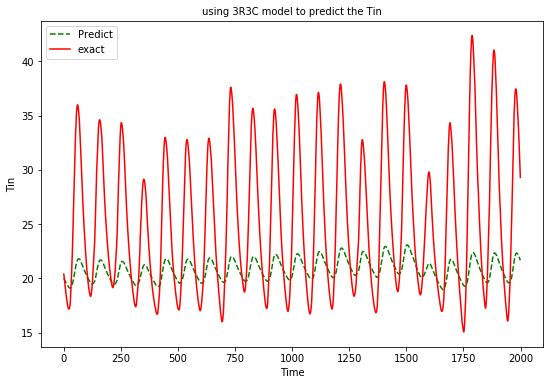

In [16]:
plot(Tins,data_train1,"try.png")

# 遗传算法

In [17]:
from tqdm import tqdm #显示运行进度

In [18]:
#遗传算法

class GA():
    def __init__(self,data,NIND=100,MAXGEN=50,maxormin = 1,GGAP=0.8,recopt = 0.9,pm = 0.1,SUBPOP = 1):
        '''
        data                     #数据集
        NIND = 100                # 种群规模
        MAXGEN = 50            # 最大遗传代数
        GGAP = 0.8               # 代沟：子代与父代个体不相同的概率为0.8
        recopt = 0.9             # 交叉概率                                                      
        pm = 0.1                 # 变异概率
        SUBPOP = 1               # 设置种群数为1
        maxormin = 1             # 设置最大最小化目标标记为1，表示是最小化目标，-1则表示最大化目标
        '''
        self.data = data
        self.NIND = NIND
        self.MAXGEN = MAXGEN
        self.maxormin = maxormin
        self.GGAP = GGAP
        self.recopt = recopt
        self.pm = pm
        self.SUBPOP = 1
    
    def aimfuc(self, Phen, LegV): 
        c0 = np.array([Phen[:, 0]]).T # 取出Phen第一列得到种群所有个体的x值
        c1 = np.array([Phen[:, 1]]).T # 取出Phen第二列得到种群所有个体的y值
        c2 = np.array([Phen[:, 2]]).T
        r0 = np.array([Phen[:, 3]]).T
        r1 = np.array([Phen[:, 4]]).T
        r2 = np.array([Phen[:, 5]]).T


        #idx1 = np.where(c0 < 0.01)[0]
        #idx2 = np.where(c1 < 0.01)[0]
        #idx3 = np.where(c2 < 0.01)[0]
        #exIdx = np.unique(np.hstack([idx1, idx2, idx3]))

        results = []
        for i in range(len(c0)):
            RK4 = RungeKutta4(self.data["tout"],Tw0,Tin0,Tim0,c0[i],c1[i],c2[i],r0[i],r1[i],r2[i],self.data["Qsolar"],self.data["Qin"],self.data["Qc"],h)
            _,_,Tins = RK4.run()
            #result = np.sum((Tins - self.data['tin'])**2)
            #result = np.sqrt(np.sum((Tins - self.data['tin'])**2) / (self.data.shape[0] - 1))
            cost = costFunc(Tins,self.data)
            results.append(cost/4)
        results = np.array(results).reshape(-1,1)
        #results[exIdx] = 10**10
        return [results, LegV]
    
    def parameterSet(self):
        """============================变量设置============================"""
        c0 = [6, 7]; c1 = [0.035, 0.04];  c2 = [50.5, 52] ; r0 = [54, 55.5]; r1 = [20.5, 21.5];  r2 = [28.5, 29.5] ;    # 自变量范围
        b0 = [0, 1];  b1 = [0, 1];   b2 = [0, 1];    b3 = [0, 1];   b4 = [0, 1];    b5 = [0, 1]         # 自变量边界
        codes = [1, 1, 1, 1, 1, 1]                     # 变量的编码方式，2个变量均使用格雷编码
        precisions =[6, 6, 6, 6, 6, 6]                 # 变量的精度，10表示精确到小数点后10位
        scales = [0, 0, 0, 0, 0, 0]                    # 采用算术刻度
        ranges=np.vstack([c0,c1,c2,r0,r1,r2]).T       # 生成自变量的范围矩阵
        borders=np.vstack([b0, b1, b2, b3, b4, b5]).T      # 生成自变量的边界矩阵

        """========================遗传算法参数设置========================="""
        #NIND = 100                # 种群规模
        #MAXGEN = 50            # 最大遗传代数
        #GGAP = 0.8               # 代沟：子代与父代个体不相同的概率为0.8
        selectStyle = 'rws'; #rws    # 遗传算法的选择方式设为"sus"——随机抽样选择
        recombinStyle = 'xovdp'  # 遗传算法的重组方式，设为两点交叉
        #recopt = 0.9             # 交叉概率                                                      
        #pm = 0.1                 # 变异概率
        #SUBPOP = 1               # 设置种群数为1
        #maxormin = 1             # 设置最大最小化目标标记为1，表示是最小化目标，-1则表示最大化目标
        
        return ranges,borders,precisions,codes,scales,selectStyle,recombinStyle
    
    def run(self,ranges,borders,precisions,codes,scales,selectStyle,recombinStyle):
        """=========================开始遗传算法进化========================"""
        
        FieldD = ga.crtfld(ranges,borders,precisions,codes,scales) # 调用函数创建区域描述器
        Lind = np.sum(FieldD[0, :]) # 计算编码后的染色体长度
        Chrom = ga.crtbp(self.NIND, Lind) # 根据区域描述器生成二进制种群
        Phen = ga.bs2rv(Chrom, FieldD) #对初始种群进行解码
        LegV = np.ones((self.NIND, 1)) # 初始化种群的可行性列向量
        [ObjV,LegV] = self.aimfuc(Phen, LegV) # 计算初始种群个体的目标函数值
        # 定义进化记录器，初始值为nan
        pop_trace = (np.zeros((self.MAXGEN, 2)) * np.nan)
        # 定义种群最优个体记录器，记录每一代最优个体的染色体，初始值为nan
        ind_trace = (np.zeros((self.MAXGEN, Lind)) * np.nan)
        # 开始进化！！
        start_time = time.time() # 开始计时
        for gen in tqdm(range(self.MAXGEN)):
            #print("第 %s 代"%gen)
            FitnV = ga.ranking(self.maxormin * ObjV, LegV) # 根据目标函数大小分配适应度值
            SelCh=ga.selecting(selectStyle, Chrom, FitnV, self.GGAP, self.SUBPOP) # 选择
            SelCh=ga.recombin(recombinStyle, SelCh, self.recopt, self.SUBPOP) #交叉
            SelCh=ga.mutbin(SelCh, self.pm) # 二进制种群变异
            Phen = ga.bs2rv(SelCh, FieldD) # 对育种种群进行解码(二进制转十进制)
            LegVSel = np.ones((SelCh.shape[0], 1)) # 初始化育种种群的可行性列向量
            [ObjVSel,LegVSel] = self.aimfuc(Phen, LegVSel) # 求育种个体的目标函数值
            [Chrom,ObjV,LegV] = ga.reins(Chrom,SelCh,self.SUBPOP,1,1,self.maxormin*ObjV,self.maxormin*ObjVSel
            ,ObjV,ObjVSel,LegV,LegVSel) # 重插入得到新一代种群
            # 记录
            pop_trace[gen, 1] = np.sum(ObjV) / ObjV.shape[0] # 记录当代种群的目标函数均值
            if self.maxormin == 1:
                best_ind = np.argmin(ObjV) # 计算当代最优个体的序号
            elif self.maxormin == -1:
                best_ind = np.argmax(ObjV)
            pop_trace[gen, 0] = ObjV[best_ind] # 记录当代种群最优个体目标函数值
            ind_trace[gen, :] = Chrom[best_ind, :] # 记录当代种群最优个体的变量值
            # 进化完成
        end_time = time.time() # 结束计时
        totalTime = end_time - start_time
        return FieldD,ind_trace,pop_trace,totalTime
    
    def results(self,FieldD,ind_trace,pop_trace,totalTime):
        results = []
        """============================绘图================================"""
        ga.trcplot(pop_trace, [['最优个体目标函数值','种群的目标函数均值']], ['demo_result'])
        
        """============================输出结果============================"""
        best_gen = np.argmin(pop_trace[:, 0]) # 计算最优种群是在哪一代
        cost = np.min(pop_trace[:, 0])
        print('最优的目标函数值为：', cost)
        print('最优的控制变量值为：')
        # 最优个体记录器存储的是各代种群最优个体的染色体，此处需要解码得到对应的基因表现型
        variables = ga.bs2rv(ind_trace, FieldD) # 解码
        for i in range(variables.shape[1]):
            print(variables[best_gen, i])
            results.append(variables[best_gen, i])
        print('最优的一代是第',best_gen + 1,'代')
        print('用时：', totalTime, '秒')
        return results,cost
    
    def plot(self,results,filename):
        
        RK4 = RungeKutta4(self.data["tout"],Tw0,Tin0,Tim0,results[0],results[1],results[2],results[3],results[4],results[5],self.data["Qsolar"],self.data["Qin"],self.data["Qc"],h)
        _,_,Tins = RK4.run()
        
        plot(Tins,self.data,filename)
    
    def main(self,filename):
        
        ranges,borders,precisions,codes,scales,selectStyle,recombinStyle = self.parameterSet()
        
        FieldD,ind_trace,pop_trace,totalTime = self.run(ranges,borders,precisions,codes,scales,selectStyle,recombinStyle)
        
        pos,cost = self.results(FieldD,ind_trace,pop_trace,totalTime)
        
        self.plot(pos,filename)
    

In [19]:
Ga = GA(data_train1,100,400,1)

100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [4:10:48<00:00, 37.62s/it]


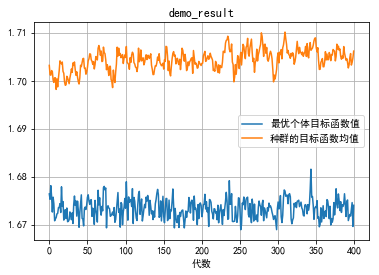

最优的目标函数值为： 1.6689513807861784
最优的控制变量值为：
6.9337663650512695
0.0350482177734375
51.40026593208313
55.26994442939758
20.507221221923828
28.538151741027832
最优的一代是第 252 代
用时： 15048.032619714737 秒


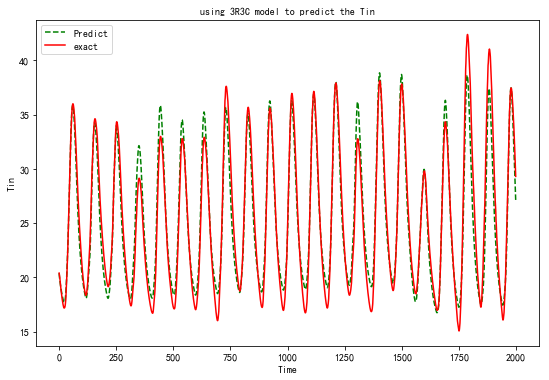

In [37]:
filename = "ga_data_train1.png"
Ga.main(filename)

## 测试模型

In [20]:
Tin0 = data_train1["tin"][0]
c0 = 6.93
c1 = 0.035
c2 = 51.4
r0 = 55.27
r1 = 20.5
r2 = 28.54

RK4 = RungeKutta4(data_train1["tout"],Tw0,Tin0,Tim0,c0,c1,c2,r0,r1,r2,data_train1["Qsolar"],data_train1["Qin"],data_train1["Qc"],h)
_,_,Tins = RK4.run()


In [21]:
costFunc(Tins,data_train1)

1.8257076133954686

In [22]:
Tin0 = data_test1["tin"][0]
c0 = 6.93
c1 = 0.035
c2 = 51.4
r0 = 55.27
r1 = 20.5
r2 = 28.54

RK4 = RungeKutta4(data_test1["tout"],Tw0,Tin0,Tim0,c0,c1,c2,r0,r1,r2,data_test1["Qsolar"],data_test1["Qin"],data_test1["Qc"],h)
_,_,Tins = RK4.run()


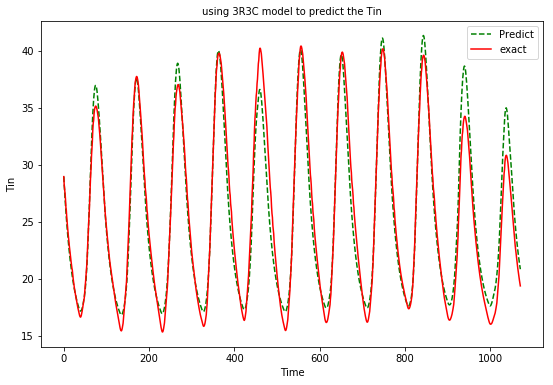

In [23]:
plot(Tins,data_test1,"ga_train_test1.png")

In [24]:
costFunc(Tins,data_test1)

1.6295171354660845

# 粒子群算法

In [19]:
from pyswarm import pso

In [20]:
class PSO1():
    def __init__(self,data):
        self.data = data
    
    def myfunc(self,x):
        c0 = x[0]
        c1 = x[1]
        c2 = x[2]
        r0 = x[3]
        r1 = x[4]
        r2 = x[5]

        RK4 = RungeKutta4(self.data["tout"],Tw0,Tin0,Tim0,c0,c1,c2,r0,r1,r2,self.data["Qsolar"],self.data["Qin"],self.data["Qc"],h)
        _,_,Tins = RK4.run()
        
        return costFunc(Tins,self.data)

    def run(self):
        
        lb = [6, 0.03, 50.5, 54, 20.5,  28.5]
        ub = [7, 0.04, 52, 55.5, 21.5, 29.5]

        xopt1, fopt1 = pso(self.myfunc, lb, ub)

        print('The optimum is at:')
        print('    {}'.format(xopt1))
        print('Optimal function value:')
        print('    myfunc: {}'.format(fopt1))
        return xopt1,fopt1
    
    def plot(self,pos,filename):
        
        RK4 = RungeKutta4(self.data["tout"],Tw0,Tin0,Tim0,pos[0],pos[1],pos[2],pos[3],pos[4],pos[5],self.data["Qsolar"],self.data["Qin"],self.data["Qc"],h)
        _,_,Tins = RK4.run()
        
        plot(Tins,self.data,filename)
    
    def main(self,filename):
        pos,cost = self.run()
        self.plot(pos,filename)


Stopping search: Swarm best objective change less than 1e-08
The optimum is at:
    [7.00000000e+00 3.58534560e-02 5.20000000e+01 5.49024707e+01
 2.05000000e+01 2.85000000e+01]
Optimal function value:
    myfunc: 1.8132186351523598


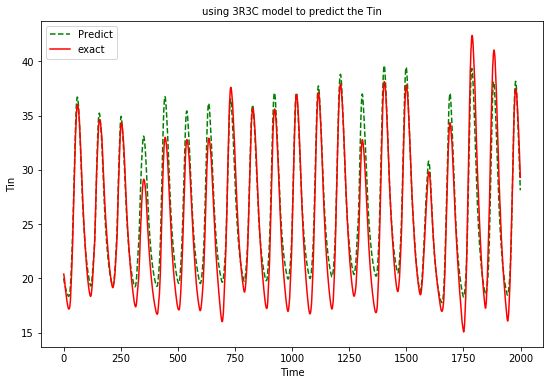

In [21]:
Tin0 = 20
pso1 = PSO1(data_train1)
filename = "pso1_data_train1.png"
pso1.main(filename)

In [22]:
Tw0 = 13
Tin0 = data_test1["tin"][0]
Tim0 = 15

c0 = 6.757
c1 = 0.0356
c2 = 51
r0 = 54.927
r1 = 21
r2 = 29
RK4 = RungeKutta4(data_test1["tout"],Tw0,Tin0,Tim0,c0,c1,c2,r0,r1,r2,data_test1["Qsolar"],data_test1["Qin"],data_test1["Qc"],h)
_,_,Tins = RK4.run()

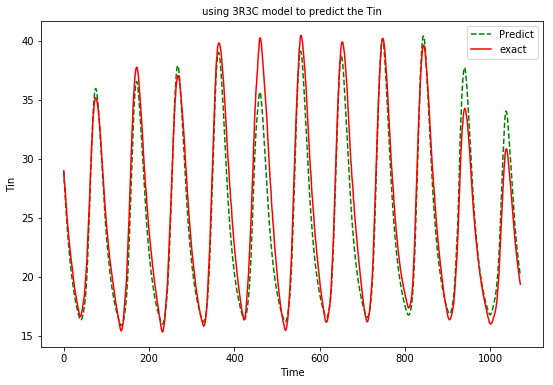

In [23]:
plot(Tins,data_test1,"data_test1.png")

In [24]:
costFunc(Tins,data_test1)

1.773393594952855

### 粒子群算法2

In [23]:
from pyswarms.single.global_best import GlobalBestPSO

In [24]:
class PSO2():
    def __init__(self,data,n_particles = 50, c1 = 0.5,c2 = 0.3, w = 0.9,iter_num=400,fast=True):
        self.data = data
        self.n_particles = n_particles
        self.c1 = c1
        self.c2 = c2
        self.w = w
        self.iter_num = iter_num
        self.fast = fast
        
    def aimfunc(self,x):
        
        c0 = x[:, 0] 
        c1 = x[:, 1] 
        c2 = x[:, 2]
        r0 = x[:, 3]
        r1 = x[:, 4]
        r2 = x[:, 5]

        results = []
        for i in range(len(c0)):
            RK4 = RungeKutta4(self.data["tout"],Tw0,Tin0,Tim0,c0[i],c1[i],c2[i],r0[i],r1[i],r2[i],self.data["Qsolar"],self.data["Qin"],self.data["Qc"],h)
            _,_,Tins = RK4.run()
            #result = np.sum((Tins - self.data['tin'])**2)
            result = costFunc(Tins,self.data)
            results.append(result)
        results = np.array(results)
        #print(type(results))
        #print(results.shape)
        return results
    
    def run(self):
        lowerBound = [6, 0.03, 50.5, 54, 20.5,  28.5]
        upperBound = [7, 0.04, 51.5, 55, 21.5, 29.5]
        x_max = np.array(upperBound)
        x_min = np.array(lowerBound)
        bounds = (x_min, x_max)

        options = {'c1': self.c1, 'c2': self.c2, 'w': self.w}

        optimizer = GlobalBestPSO(n_particles = self.n_particles, dimensions= x_max.shape[0], options=options, bounds=bounds)

        cost, pos = optimizer.optimize(self.aimfunc, self.iter_num, fast = self.fast)
        return cost,pos
    
    def plot(self,pos,filename):
        
        RK4 = RungeKutta4(self.data["tout"],Tw0,Tin0,Tim0,pos[0],pos[1],pos[2],pos[3],pos[4],pos[5],self.data["Qsolar"],self.data["Qin"],self.data["Qc"],h)
        _,_,Tins = RK4.run()
        
        plot(Tins,self.data,filename)
        
    def main(self,filename):
        cost,pos = self.run()
        self.plot(pos,filename)

2019-05-29 10:30:23,331 - pyswarms.single.global_best - INFO - Optimize for 400 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|█████████████████████████████████████████████████████████████|400/400, best_cost=1.82
2019-05-29 11:59:43,899 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.8209511051280654, best pos: [6.99495857e+00 3.57024297e-02 5.07037975e+01 5.45370392e+01
 2.05054286e+01 2.85823505e+01]


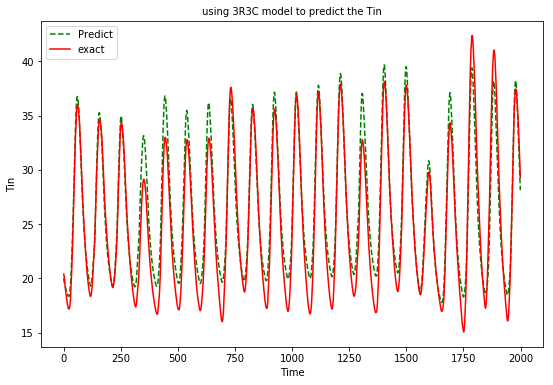

In [25]:
Tin0 = 20
pso2 = PSO2(data_train1)
filename = "pso2_data_train1.png"
pso2.main(filename)

In [26]:
Tin0 = data_test1["tin"][0]
Tim0 = 15

c0 = 6.995
c1 = 0.0357
c2 = 50.7
r0 = 54.537
r1 = 20.5
r2 = 28.58
RK4 = RungeKutta4(data_test1["tout"],Tw0,Tin0,Tim0,c0,c1,c2,r0,r1,r2,data_test1["Qsolar"],data_test1["Qin"],data_test1["Qc"],h)
_,_,Tins = RK4.run()


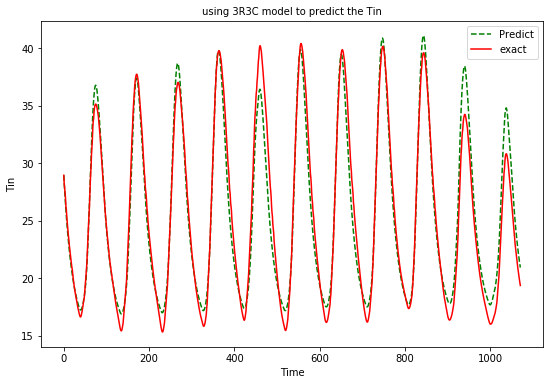

In [27]:
plot(Tins,data_test1,"pso2_data_test1.png")

In [28]:
costFunc(Tins,data_test1)

1.6009190092765835

## 训练数据2

100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [5:11:47<00:00, 46.77s/it]


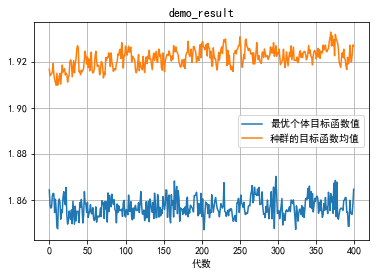

最优的目标函数值为： 1.8471185945529258
最优的控制变量值为：
6.017607688903809
0.0399993896484375
50.955178022384644
55.06152820587158
21.417838096618652
29.43570041656494
最优的一代是第 204 代
用时： 18707.292151212692 秒


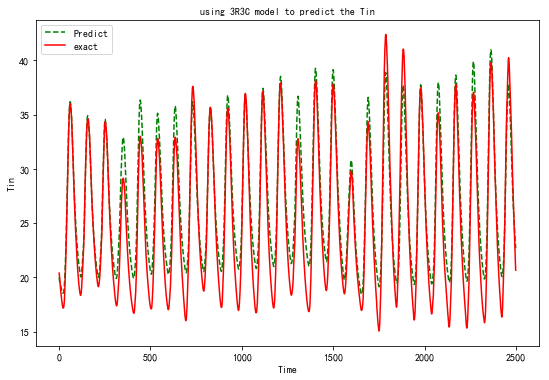

In [19]:
#遗传算法

#训练
Ga = GA(data_train2,100,400,1)

filename = "ga_data_train2.png"
Ga.main(filename)

In [17]:
Tin0 = data_train2["tin"][0]
c0 = 6.02
c1 = 0.04
c2 = 50.955
r0 = 55.06
r1 = 21.42
r2 = 29.44

RK4 = RungeKutta4(data_train2["tout"],Tw0,Tin0,Tim0,c0,c1,c2,r0,r1,r2,data_train2["Qsolar"],data_train2["Qin"],data_train2["Qc"],h)
_,_,Tins = RK4.run()

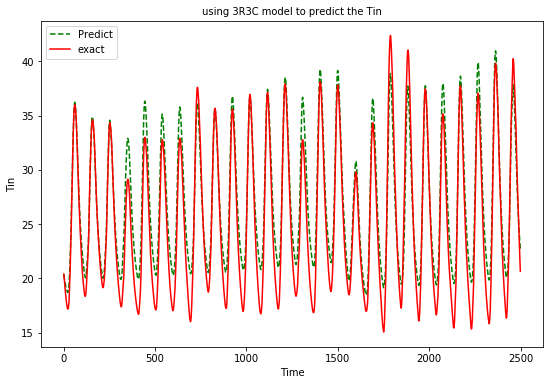

In [18]:
plot(Tins,data_train2,"ga_train_train2.png")

In [19]:
costFunc(Tins,data_train2)

2.2158006555022953

In [20]:
#验证模型

Tin0 = data_test2["tin"][0]
c0 = 6.02
c1 = 0.04
c2 = 50.955
r0 = 55.06
r1 = 21.42
r2 = 29.44

RK4 = RungeKutta4(data_test2["tout"],Tw0,Tin0,Tim0,c0,c1,c2,r0,r1,r2,data_test2["Qsolar"],data_test2["Qin"],data_test2["Qc"],h)
_,_,Tins = RK4.run()


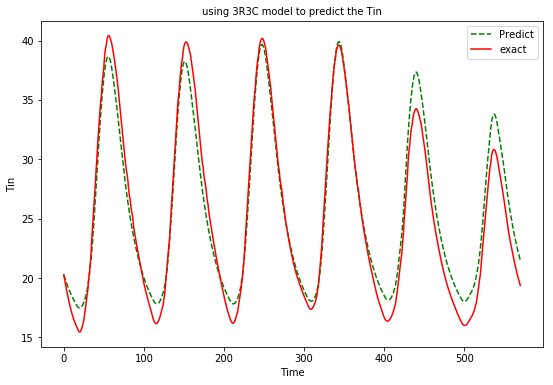

In [21]:
plot(Tins,data_test2,"ga_train_test2.png")

In [22]:
costFunc(Tins,data_test2)

1.600137646982208

Stopping search: Swarm best objective change less than 1e-08
The optimum is at:
    [6.99999989e+00 3.57928642e-02 5.12412570e+01 5.50387413e+01
 2.08876613e+01 2.90421984e+01]
Optimal function value:
    myfunc: 1.5099686274997084


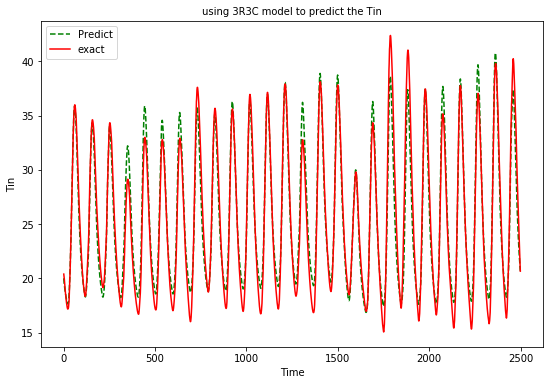

In [25]:
#粒子群算法

#训练
Tin0 = 20
pso1 = PSO1(data_train2)
filename = "pso2_data_train2.png"
pso1.main(filename)

In [26]:
#验证模型

Tin0 = data_test2["tin"][0]
Tim0 = 15

c0 = 7
c1 = 0.0358
c2 = 51.97
r0 = 55.5
r1 = 20.72
r2 = 29.34
RK4 = RungeKutta4(data_test2["tout"],Tw0,Tin0,Tim0,c0,c1,c2,r0,r1,r2,data_test2["Qsolar"],data_test2["Qin"],data_test2["Qc"],h)
_,_,Tins = RK4.run()


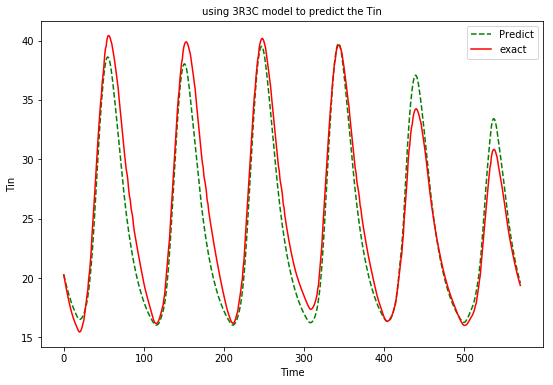

In [27]:
plot(Tins,data_test2,"pso2_data_test2.png")

In [91]:
costFunc(Tins,data_test2)

1.8194938210653817